In [1]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
from liverModel import *
from liverData import *

Using TensorFlow backend.


In [3]:
num_of_epochs = 1
global_best_metric = 0
def read_ct(path):
    img = nib.load(path)
    img = img.get_data()
    return img
def loadCT(path):
    images = glob.glob(path+"/volume*")
    segmentations = glob.glob(path+"/segmentation*", )
    images = sorted(images)
    segmentations = sorted(segmentations)
    return images , segmentations
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [8]:
def trainUnet(model,model_checkpoint,num_channels=2,num_ct=1,folders=2,batch_size=8):
    """
        Training by taking ct scans of only num_ct files and each data point of shape
        (512,512,num_channels)
    """
    path = "../data/batch"
    images ,segmentations = loadCT(path)
    for i in range(0,len(images),num_ct):
        print("image " + str(i)+" out of "+str(len(images)))
        X_train = []
        y_train = []
        img = read_ct(images[i])
        seg = read_ct(segmentations[i])
        print("Shape of img : ", img.shape)
        ##img shape: (512,512,X) X is the sum of all slices of num_ct files
        for j in range(0,img.shape[2]):
            ## simg shape (512,512)
            simg = img[:,:,j].astype(float)
            sseg = seg[:,:,j]
            ##HU clipping
            simg[simg >250 ] = 250
            simg[simg < -200] = -200
            ## Normalization
            simg -= -200
            simg /= 450
            ## treating tumor as part of liver
            sseg[sseg > 0] = 1
            if np.sum(sseg == 1)>0 :
                X_train.append(simg)
                y_train.append(sseg)
        print("Len of X_train ",len(X_train))
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        X_train = X_train[...,np.newaxis]
        y_train = y_train[...,np.newaxis]
#         mean = np.mean(X_train)  # mean for data centering
#         std = np.std(X_train)  # std for data normalization

#         X_train -= mean
#         X_train /= std
        print("shape of X_train ",X_train.shape)
        print("Shape of y_train ",y_train.shape)
        model.fit(X_train,y_train,callbacks=[model_checkpoint],batch_size=batch_size) ## set epoch to 1
    return model

In [9]:
def evaluate(model,fromIndex,batch_size=8):
    path = "../data/Test"
    images ,segmentations = loadCT(path)
    histot = []
    for i in range(fromIndex,len(images)):
        print("image " + str(i))
        X_test = []
        y_test = []
        img = read_ct(images[i])
        seg = read_ct(segmentations[i])
        print("Shape of img : ", img.shape)
        ##img shape: (512,512,X) X is the sum of all slices of num_ct files
        for j in range(0,img.shape[2]):
            simg = img[:,:,j].astype(float)
            sseg = seg[:,:,j]
            ## simg shape (512,512)
            ##HU clipping
            simg[simg >250 ] = 250
            simg[simg < -200] = -200
            ## Normalization
            simg -= -200
            simg /= 450
            ## treating tumor as part of liver
            sseg[sseg > 0] = 1
            if np.sum(sseg == 1)>0 :
                X_test.append(simg)
                y_test.append(sseg)
        print("Len of X_test ",len(X_test))
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        X_test = X_test[...,np.newaxis]
        y_test = y_test[...,np.newaxis]
#         mean = np.mean(X_test)  # mean for data centering
#         std = np.std(X_test)  # std for data normalization

#         X_test -= mean
#         X_test /= std
        print("shape of X_train ",X_test.shape)
        print("Shape of y_train ",y_test.shape)
        history = model.evaluate(X_test,y_test,batch_size=batch_size)
        print(history)
        histot.append(history)
    return histot

In [6]:
num_channels = 1
num_ct = 1
# model = liverUnet(input_size=(512,512,num_channels))
model = get_unet_sorr(input_size=(512,512,num_channels))
model_checkpoint = ModelCheckpoint('unet_liver_preprocess.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [11]:
num_epochs = 2
for e in range(num_epochs):
    model = trainUnet(model,model_checkpoint,num_channels=num_channels,num_ct=num_ct,folders=1,batch_size=10)

image 0 out of 111
Shape of img :  (512, 512, 685)
Len of X_train  276
shape of X_train  (276, 512, 512, 1)
Shape of y_train  (276, 512, 512, 1)
Epoch 1/1
276/276 [==============================] - 18s 67ms/step - loss: 0.1460 - dice_coef: 0.4285

Epoch 00001: loss improved from 0.43476 to 0.14604, saving model to unet_liver_preprocess.hdf5
image 1 out of 111
Shape of img :  (512, 512, 683)
Len of X_train  259
shape of X_train  (259, 512, 512, 1)
Shape of y_train  (259, 512, 512, 1)
Epoch 1/1
259/259 [==============================] - 20s 79ms/step - loss: 0.1542 - dice_coef: 0.4953

Epoch 00001: loss did not improve from 0.14604
image 2 out of 111
Shape of img :  (512, 512, 677)
Len of X_train  266
shape of X_train  (266, 512, 512, 1)
Shape of y_train  (266, 512, 512, 1)
Epoch 1/1
266/266 [==============================] - 18s 68ms/step - loss: 0.0904 - dice_coef: 0.6299

Epoch 00001: loss improved from 0.14604 to 0.09036, saving model to unet_liver_preprocess.hdf5
image 3 out of 111


Len of X_train  227
shape of X_train  (227, 512, 512, 1)
Shape of y_train  (227, 512, 512, 1)
Epoch 1/1
227/227 [==============================] - 18s 81ms/step - loss: 0.0432 - dice_coef: 0.8044

Epoch 00001: loss did not improve from 0.02499
image 28 out of 111
Shape of img :  (512, 512, 654)
Len of X_train  292
shape of X_train  (292, 512, 512, 1)
Shape of y_train  (292, 512, 512, 1)
Epoch 1/1
292/292 [==============================] - 20s 70ms/step - loss: 0.0772 - dice_coef: 0.6990

Epoch 00001: loss did not improve from 0.02499
image 29 out of 111
Shape of img :  (512, 512, 338)
Len of X_train  277
shape of X_train  (277, 512, 512, 1)
Shape of y_train  (277, 512, 512, 1)
Epoch 1/1
277/277 [==============================] - 19s 69ms/step - loss: 0.0508 - dice_coef: 0.8836

Epoch 00001: loss did not improve from 0.02499
image 30 out of 111
Shape of img :  (512, 512, 624)
Len of X_train  241
shape of X_train  (241, 512, 512, 1)
Shape of y_train  (241, 512, 512, 1)
Epoch 1/1
241/241 

Len of X_train  113
shape of X_train  (113, 512, 512, 1)
Shape of y_train  (113, 512, 512, 1)
Epoch 1/1
113/113 [==============================] - 8s 71ms/step - loss: 0.0422 - dice_coef: 0.8048

Epoch 00001: loss did not improve from 0.02323
image 56 out of 111
Shape of img :  (512, 512, 74)
Len of X_train  59
shape of X_train  (59, 512, 512, 1)
Shape of y_train  (59, 512, 512, 1)
Epoch 1/1
59/59 [==============================] - 4s 71ms/step - loss: 0.0606 - dice_coef: 0.7940

Epoch 00001: loss did not improve from 0.02323
image 57 out of 111
Shape of img :  (512, 512, 124)
Len of X_train  41
shape of X_train  (41, 512, 512, 1)
Shape of y_train  (41, 512, 512, 1)
Epoch 1/1
41/41 [==============================] - 3s 69ms/step - loss: 0.0395 - dice_coef: 0.7360

Epoch 00001: loss did not improve from 0.02323
image 58 out of 111
Shape of img :  (512, 512, 225)
Len of X_train  85
shape of X_train  (85, 512, 512, 1)
Shape of y_train  (85, 512, 512, 1)
Epoch 1/1
85/85 [==================

Len of X_train  58
shape of X_train  (58, 512, 512, 1)
Shape of y_train  (58, 512, 512, 1)
Epoch 1/1
58/58 [==============================] - 4s 69ms/step - loss: 0.0675 - dice_coef: 0.7053

Epoch 00001: loss did not improve from 0.01792
image 84 out of 111
Shape of img :  (512, 512, 121)
Len of X_train  50
shape of X_train  (50, 512, 512, 1)
Shape of y_train  (50, 512, 512, 1)
Epoch 1/1
50/50 [==============================] - 3s 70ms/step - loss: 0.0367 - dice_coef: 0.7819

Epoch 00001: loss did not improve from 0.01792
image 85 out of 111
Shape of img :  (512, 512, 107)
Len of X_train  32
shape of X_train  (32, 512, 512, 1)
Shape of y_train  (32, 512, 512, 1)
Epoch 1/1
32/32 [==============================] - 2s 71ms/step - loss: 0.0798 - dice_coef: 0.7982

Epoch 00001: loss did not improve from 0.01792
image 86 out of 111
Shape of img :  (512, 512, 89)
Len of X_train  37
shape of X_train  (37, 512, 512, 1)
Shape of y_train  (37, 512, 512, 1)
Epoch 1/1
37/37 [=======================

In [42]:
model.save_weights('unet_liver_after_epoch1.hdf5')

# Validation

In [14]:
# model.load_weights('unet_liver_preprocess.hdf5')
# model.load_weights('unet_liver_after_epoch.hdf5')
h = evaluate(model,0,batch_size=2)

image 0
Shape of img :  (512, 512, 75)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 25ms/step
[0.04874188478650718, 0.7980236771420158]
image 1
Shape of img :  (512, 512, 123)
Len of X_test  29
shape of X_train  (29, 512, 512, 1)
Shape of y_train  (29, 512, 512, 1)
29/29 [==============================] - 1s 25ms/step
[0.046956539154052734, 0.7862053013824183]
image 2
Shape of img :  (512, 512, 501)
Len of X_test  181
shape of X_train  (181, 512, 512, 1)
Shape of y_train  (181, 512, 512, 1)
181/181 [==============================] - 4s 24ms/step
[0.030018469190111807, 0.8288133678420283]
image 3
Shape of img :  (512, 512, 466)
Len of X_test  167
shape of X_train  (167, 512, 512, 1)
Shape of y_train  (167, 512, 512, 1)
167/167 [==============================] - 4s 24ms/step
[0.09615366968387615, 0.749588297664597]
image 4
Shape of img :  (512, 512, 455)
Len of X_test  189
shape of X_train  (189, 512

In [18]:
alp = np.array(h)
y = np.mean(alp,axis=0)
print(y)
print(global_best_metric)
if y[1]>global_best_metric[1]:
    global_best_metric = y

[0.05649071 0.74752174]
[0.05649071 0.74752174]


In [19]:
# model.load_weights('unet_liver_after_epoch.hdf5')

# Testing

In [29]:
images ,segmentations = loadCT("../data/Test")
img = read_ct(images[11])
seg = read_ct(segmentations[11])
X_test = []
y_test = []
for j in range(0,img.shape[2]):
    simg = img[:,:,j].astype(float)
    sseg = seg[:,:,j]
    ## simg shape (512,512)
    ##HU clipping
    simg[simg >250 ] = 250
    simg[simg < -200] = -200
    ## Normalization
    simg -= -200
    simg /= 450
    ## treating tumor as part of liver
    sseg[sseg > 0] = 1
    if np.sum(sseg == 1)>0 :
        X_test.append(simg)
        y_test.append(sseg)
print("Len of X_test ",len(X_test))
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test[...,np.newaxis]
y_test = y_test[...,np.newaxis]
print("shape of X_train ",X_test.shape)
print("Shape of y_train ",y_test.shape)
# history = model.evaluate(X_test,y_test,batch_size=batch_size)


Len of X_test  188
shape of X_train  (188, 512, 512, 1)
Shape of y_train  (188, 512, 512, 1)


In [37]:
idx = 100

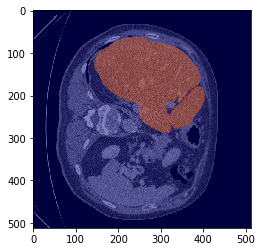

In [38]:
plt.imshow(X_test[idx][:,:,0].reshape(512,512), cmap="gray")
plt.imshow(y_test[idx][:,:,0].reshape(512,512), cmap='jet', alpha=0.5)

In [39]:
result = model.predict(X_test[idx:idx+1])

In [40]:
result.shape

(1, 512, 512, 1)

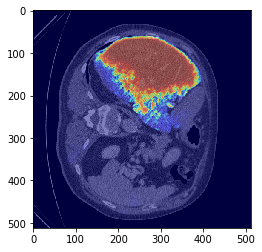

In [41]:
plt.imshow(X_test[idx][:,:,0].reshape(512,512), cmap="gray")
plt.imshow(result[0][:,:,0].reshape(512,512), cmap='jet', alpha=0.5)

In [ ]:
np.sum(result>0)